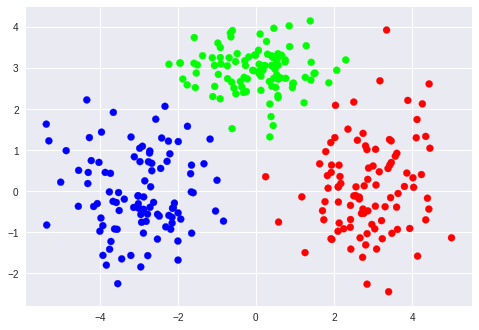

In [1]:
import numpy as np
import sklearn.cluster
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

np.random.seed(12345)
# データ数と真のパラメータを指定して、真の関数を構築する
def f(n):
  x1=np.array([np.random.normal(-3,1,n),np.random.normal(0,1,n)])
  x2=np.array([np.random.normal(3,1,n),np.random.normal(0,1,n)])
  x3=np.array([np.random.normal(0,1,n),np.random.normal(3,0.5,n)])
  x=np.concatenate([x1,x2,x3],axis=1)
  return 3*n,x.T
N,data_x=f(100)
#model = GaussianMixture(n_components=3)
model=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300)
data_y=model.fit_predict(data_x)

# 描画する
import matplotlib.pyplot as plt
plt.scatter(data_x[:,0],data_x[:,1],c=data_y,cmap='brg')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


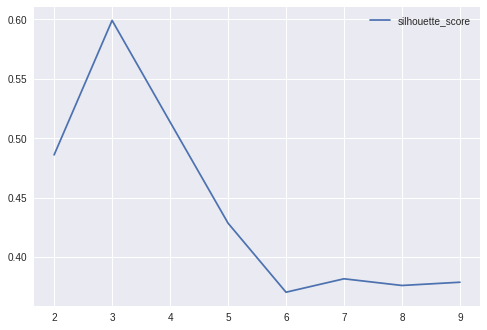

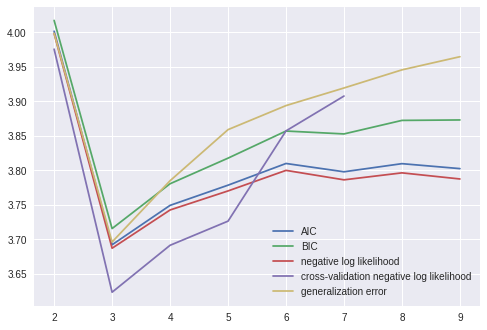

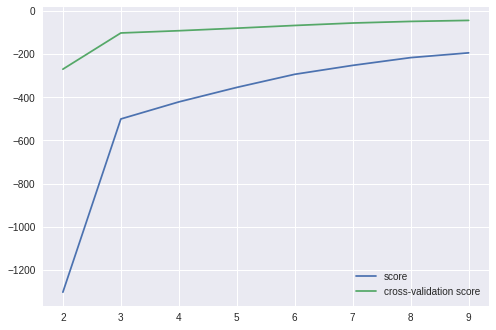

In [0]:
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold,LeaveOneOut

N_test,test_x=f(1000)

def compute_ll(km,X,y):
  #number of clusters
  K = km.n_clusters
  #size of data set
  N, D = X.shape
  
  #compute center and variance for all clusters
  centers = km.cluster_centers_
  cov=[None for k in range(K)]
  for k in range(K):
    Xc=X[y==k]
    cov[k] = np.cov(Xc.T)

  try:
    # compute log likelihood
    LL=[0.0 for k in range(K)]
    for k in range(K):
      Xc=X[y==k]
      Nc=Xc.shape[0]*1.0
      LL[k]+=sum(stats.multivariate_normal.logpdf(x, centers[k], cov[k]) for x in Xc)
      LL[k]+=Nc*np.log(Nc/N)
  except:
    return np.nan
  return np.sum(LL)

def compute_bic(km,X,y):
  #number of clusters
  K = km.n_clusters
  #size of data set
  N, D = X.shape
  LL=compute_ll(km,X,y)
  BIC=-1*LL+ 0.5*K * np.log(N)
  return(BIC)

def compute_aic(km,X,y):
  #number of clusters
  K = km.n_clusters
  LL=compute_ll(km,X,y)
  AIC=-1*LL+ 0.5*K
  return(AIC)

def compute_cv_score(data_x):
  kf=KFold(n_splits=5,shuffle=True)
  cv_error=[]
  for train_index, test_index in kf.split(data_x):
    km_cv=sklearn.cluster.KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=300)
    cv_x_train, cv_x_test = data_x[train_index], data_x[test_index]
    km_cv.fit(cv_x_train)
    cv_y_test=km_cv.predict(cv_x_test)
    cv_error.append(km_cv.score(cv_x_test,cv_y_test))
  return np.mean(cv_error)

def compute_cv_nll(data_x):
  kf=KFold(n_splits=5,shuffle=True)
  cv_error=[]
  for train_index, test_index in kf.split(data_x):
    km_cv=sklearn.cluster.KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=300)
    cv_x_train, cv_x_test = data_x[train_index], data_x[test_index]
    km_cv.fit(cv_x_train)
    cv_y_test=km_cv.predict(cv_x_test)
    N_cv=cv_x_test.shape[0]
    cv_error.append(-1*compute_ll(km_cv,cv_x_test,cv_y_test)/N_cv)
  return np.mean(cv_error)
          

s_list=[]
sil_list=[]
aic_list=[]
bic_list=[]
nll_list=[]
cv_nll_list=[]
ge_list=[]
cv_list=[]
cls_list=[]
for i in range(2,10):
  km=sklearn.cluster.KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=300)
  data_y=km.fit_predict(data_x)
  cls_list.append(i)
  nll_list.append(-1*compute_ll(km,data_x,data_y)/N)
  cv_nll_list.append(compute_cv_nll(data_x))
  aic_list.append(compute_aic(km,data_x,data_y)/N)
  bic_list.append(compute_bic(km,data_x,data_y)/N)
  ge_list.append(-1*compute_ll(km,test_x,km.predict(test_x))/N_test)
  sil_coeff = silhouette_score(data_x, data_y, metric='euclidean')
  sil_list.append(sil_coeff)
  s_list.append(km.score(data_x,data_y))
  cv_list.append(compute_cv_score(data_x))
    
plt.plot(cls_list,sil_list,label="silhouette_score")
plt.legend()
plt.show()

plt.plot(cls_list,aic_list,label="AIC")
plt.plot(cls_list,bic_list,label="BIC")
plt.plot(cls_list,nll_list,label="negative log likelihood")
plt.plot(cls_list,cv_nll_list,label="cross-validation negative log likelihood")
plt.plot(cls_list,ge_list,label="generalization error")
plt.legend()
plt.show()

plt.plot(cls_list,s_list,label="score")
plt.plot(cls_list,cv_list,label="cross-validation score")

plt.legend()
plt.show()

